# Setting up the environment

In [19]:
!python3 -m spacy download en_core_web_md
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 48.3 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Getting familiar with the dataset

For this project we use **[AG's corpus of news articles](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)** which is a collection of more than 1 Million News Articles, extracted from more than 2000 news resources during the duration of 1 year. You are also encouraged to take a look at conventions and concepts associated with processing text corpora in **[Analyzing Text with the Natural Language Toolkit (especially chapter 2)](https://www.nltk.org/book/ch02.html)**, which will be covered in more detail in Project 1.

Each article is pre-labeled with one of 4 news categories. This is a balanced dataset with each category containing ~30,000 articles. The news categories are:
0. World
1. Sports
2. Business
3. Sci/Tech

## Download the dataset

In [20]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("ag_news")
train = dataset.get("train").to_pandas().rename(columns={"label": "category"})
test =  dataset.get("test").to_pandas().rename(columns={"label": "category"})

## Explore the dataset

In [21]:
pd.set_option('display.max_colwidth', 0)
train.head()

,text,category
0,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",2
1,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",2
2,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,2
3,"Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",2
4,"Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",2


In [22]:
#@title Run this code to examine dataset. (Do not edit code.)
print(f"Number of records in the train sample {train.shape[0]}")
print(f"Number of records in the test sample {test.shape[0]}")

Number of records in the train sample 120000
Number of records in the test sample 7600


### Category distribution for the data

**To perform further analysis on the data, execute the commands below to examine the distribution of the four document categories (0 = World; 1 = Sports; 2 = Business; 3 = Sci/Tech).**

<Axes: xlabel='category'>

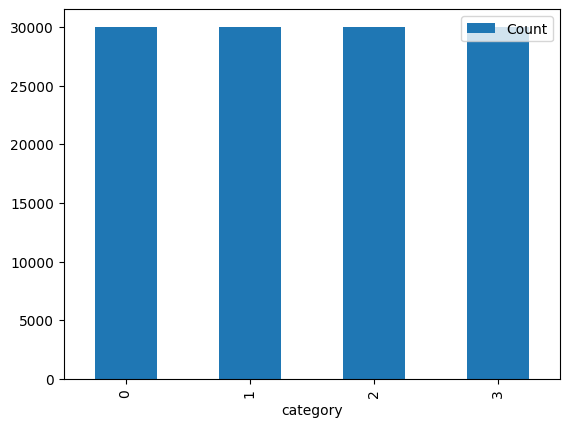

In [23]:
val_counts = train.groupby('category').count().reset_index()
val_counts = val_counts.rename(columns = {"text": "Count"})
val_counts.plot(x="category", y="Count", kind="bar")

We can observe that the categories are equally distributed

### Number of unique tokens
A large number of unique tokens (words) exists in natural language, which are extracted through the process of tokenization; the total number of tokens in a corpus is referred to as N.

In [24]:
def getCounts(df, frac):
  result = set()
  df = df.sample(frac=frac, random_state=1).reset_index(drop=True)
  df['text'].str.lower().str.split().apply(result.update)
  return df.shape[0], len(result)

counts = {}
for frac in range(10, 101, 10):
  datasize, unique_count = getCounts(train, frac/100)
  counts[datasize] = unique_count

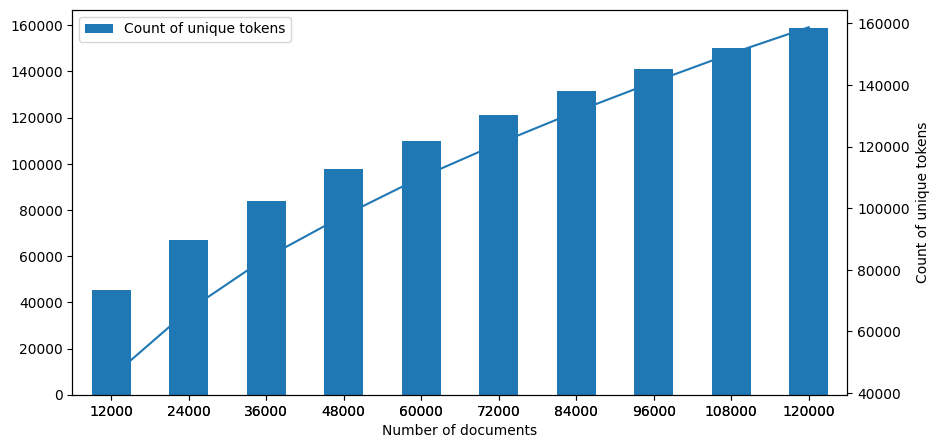

In [25]:
counts_df = pd.DataFrame(counts.items(), columns=["Number of documents", "Count of unique tokens"])

ax = counts_df['Count of unique tokens'].plot(secondary_y=True)
ax.set_xticks([])

ax2 = counts_df.plot(x="Number of documents", y = "Count of unique tokens"
, kind='bar', ax = ax, figsize=(10,5),  ylabel="Count of unique tokens",
xlabel="Number of documents")

ax2.get_xaxis().set_visible(True)

## Sampling the dataset

In [26]:
train = train.sample(frac=0.001, random_state=1).reset_index(drop=True)
test = test.sample(frac=0.01, random_state=1).reset_index(drop=True)

# Text preprocessing

To reduce noise in the data, we perform text preprocessing for Natural Language tasks. Below are the implemented preprocessing methods for:

1. Tokenization
2. Punctuation removal
3. Stop word removal  
4. Word lemmatization  

## Tokenization

In [27]:
import spacy
import string

from spacy.tokens.token import Token
from typing import List

nlp = spacy.load("en_core_web_md")
sample_text = "These are a series of demos, to show how& to use spacy **for** preprocessing tasks!"

In [28]:
def tokenize(text: str) -> List[Token]:
    """
    :param text: text as a python string object
    :return: a list of objects of type Token
    """
    doc = nlp(text)
    return [w for w in doc]

print("Sample Text: ", sample_text)
print("Tokenizer output: ", tokenize(sample_text))
print("Split output: ", sample_text.split(" "))

Sample Text:  These are a series of demos, to show how& to use spacy **for** preprocessing tasks!
Tokenizer output:  [These, are, a, series, of, demos, ,, to, show, how, &, to, use, spacy, *, *, for, *, *, preprocessing, tasks, !]
Split output:  ['These', 'are', 'a', 'series', 'of', 'demos,', 'to', 'show', 'how&', 'to', 'use', 'spacy', '**for**', 'preprocessing', 'tasks!']


In [29]:
tokens = tokenize(sample_text)

## Remove punctuation

In [32]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [39]:
def remove_punctuation(tokens: List[Token]) -> List[Token]:
    """
    :param tokens: a list of objects of type Token
    :return: a filtered list of Tokens after removing punctuation
    """

    return [token for token in tokens if token.text not in string.punctuation]
    

In [42]:
def compareLists(tokens1: List[Token], tokens2: List[str]):
    set1 = set()
    for x in tokens1:
        set1.add(x.text)

    return not set1.difference(set(tokens2))

try:
    assert compareLists(remove_punctuation(tokens), ['These', 'are', 'a', 'series', 'of', 'demos', 'to', 'show', 'how', 'to', 'use', 'spacy', 'for', 'preprocessing', 'tasks'])==True
    print("Test Passed!")
except AssertionError as e:
    print("Test Failed", e)

Test Passed!


## 2.3. Remove stop words

Stop words do not contribute much to the accuracy of the models and, in general, operate as noise. Thus, we remove the most frequent words which do not contribute significantly.


In [43]:
def remove_stop_words(tokens: List[Token]) -> List[Token]:
    """
    :param tokens: a list of objects of type Token
    :return: a filtered list of Tokens after removing stopwords
    """

    return [token for token in tokens if not token.is_stop]
    

In [44]:
try:
    assert compareLists(remove_stop_words(tokens), ['spacy', 'use', 'series','!', 'tasks', '&', ',', 'preprocessing', 'demos', '*', '*', '*', '*'])==True
    print("Test Passed!")
except AssertionError:
    print("Test Failed")
    raise

Test Passed!


## 2.4. Lemmatize Text

Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.


### 2.4.1 Programming Question #3 (2 points)

**Complete the function below for lemmatization (approx 1 to 5 lines of code). (2 points)**

<mark>After you have completed the function and executed the tests, make sure to transfer your answer to .py file provided along with this Notebook</mark>

In [46]:
def lemmatize(tokens: List[Token]) -> List[str]:
    """
    :param tokens: a list of objects of type Token
    :return: a list of type str, contains lemmatized form
    """
    return [token.lemma_ for token in tokens]

In [47]:
try:
    assert not set(lemmatize(tokens)).difference(set(['these', 'be', 'a', 'series', 'of', 'demos', ',', 'to', 'show', 'how', '&', 'to', 'use', 'spacy', '*', '*', 'for', '*', '*', 'preprocessing', 'task', '!']))
    print("Test Passed!")
except AssertionError:
    print("Test Failed")
    raise

Test Passed!
